In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../datasets/flattened_dataset.csv")

In [3]:
df.columns

Index(['shipment_id', 'customer_price', 'expected_carrier_price',
       'final_carrier_price', 'weight', 'shipment_type', 'insurance_type',
       'customer_id', 'domain_name', 'booking_state', 'lms_plus', 'exworks_id',
       'margin', 'created_date_customer', 'domain_name_customer',
       'main_industry_name_customer', 'industry_sector_name_customer',
       'segmentation_customer', 'sequence_number_customer',
       'structure_number_customer', 'is_master_customer',
       'created_date_delivery', 'domain_name_delivery', 'postal_code_delivery',
       'city_delivery', 'name_country_delivery', 'iso_country_code_delivery',
       'continent_delivery', 'EU_delivery', 'created_date_pickup',
       'domain_name_pickup', 'postal_code_pickup', 'city_pickup',
       'name_country_pickup', 'iso_country_code_pickup', 'continent_pickup',
       'EU_pickup', 'created_date_service', 'name_service', 'service_type',
       'transport_type', 'domain_name_service', 'name_carrier',
       'created_

### Helpful functions created for use later

In [4]:
def analyze_missing_values(df, column):
    """Analyze missing values in a column."""
    missing_count = df[column].isna().sum()
    total_records = len(df)
    missing_percentage = (missing_count / total_records) * 100
    
    print(f"Total missing values: {missing_count}")
    print(f"Missing percentage: {missing_percentage:.2f}%")


In [5]:
def analyze_numeric_values(df, column):
    """Analyze numeric column values and decimal places."""
    print(f"\n=== {column} ===")
    print(f"Data type: {df[column].dtype}")
    print(f"Null values: {df[column].isnull().sum()}")
    
    non_null_values = df[column].dropna()
    decimal_places = (non_null_values % 1).apply(lambda x: len(str(x).split('.')[-1]) if x > 0 else 0)
    print("\nDecimal places distribution:")
    print(decimal_places.value_counts().sort_index())
    
    print(f"\nNegative values: {(non_null_values < 0).sum()}")
    print(f"Zero values: {(non_null_values == 0).sum()}")
    print(f"Infinite values: {np.isinf(non_null_values).sum()}")


In [6]:
def analyze_text_case_consistency(df, column, show_examples=5):
    """Analyze case consistency in text columns."""
    value_counts = df[column].value_counts()
    value_lower = df[column].str.lower()
    value_lower_counts = value_lower.value_counts()
    
    print(f"\nValue counts - original: {len(value_counts)}")
    print(f"Value counts - lowercase: {len(value_lower_counts)}")
    
    if len(value_counts) != len(value_lower_counts):
        print("\nCase inconsistencies found:")
        count = 0
        for value in value_lower_counts.index:
            if count >= show_examples:
                break
            mask = df[column].str.lower() == value
            variants = df.loc[mask, column].unique()
            if len(variants) > 1:
                print(f"\nVariants for '{value}':")
                print(variants)
                count += 1


In [7]:
def analyze_postal_code(df, column):
    """Analyze postal code formatting."""
    # Filter for postal codes that contain letters
    postal_mask = df[column].str.contains('[A-Za-z]', na=False)
    postal_with_letters = df.loc[postal_mask, column]
    
    # Get value counts for original and lowercase versions
    postal_counts = postal_with_letters.value_counts()
    postal_lower = postal_with_letters.str.lower()
    postal_lower_counts = postal_lower.value_counts()
    
    print(f"Postal codes with letters - original count: {len(postal_counts)}")
    print(f"Postal codes with letters - lowercase count: {len(postal_lower_counts)}")
    
    # Find case inconsistencies
    if len(postal_counts) != len(postal_lower_counts):
        print("\nCase inconsistencies found:")
        count = 0
        for code in postal_lower_counts.index:
            if count >= 5:  # Limit to first 5 examples like in original code
                break
            variants = postal_with_letters[postal_with_letters.str.lower() == code].unique()
            if len(variants) > 1:
                print(f"\nVariants for '{code}':")
                print(variants)
                count += 1

In [8]:
def standardize_postal_code(x):
    """Standardize postal code format."""
    return x.upper() if isinstance(x, str) and any(c.isalpha() for c in x) else x


In [9]:
def standardize_city_name(x):
    """Standardize city name format."""
    return x.str.lower().str.title() if isinstance(x, str) else x


### Price analysis

Here we can view different decimal places, we should investigate that more

In [10]:
price_columns = ['customer_price', 'expected_carrier_price', 'final_carrier_price']

for col in price_columns:
    analyze_numeric_values(df, col)


=== customer_price ===
Data type: float64
Null values: 0

Decimal places distribution:
customer_price
0      38428
1       6180
2      17507
13        32
14       180
15     26029
16    377791
17    173633
18     17022
Name: count, dtype: int64

Negative values: 2
Zero values: 26343
Infinite values: 0

=== expected_carrier_price ===
Data type: float64
Null values: 0

Decimal places distribution:
expected_carrier_price
0      39264
1      18775
2      15366
13        19
14        99
15     19617
16    376559
17    170007
18     17096
Name: count, dtype: int64

Negative values: 11
Zero values: 26411
Infinite values: 0

=== final_carrier_price ===
Data type: float64
Null values: 104174

Decimal places distribution:
final_carrier_price
0      15965
1      17452
2      16531
13        10
14        68
15     17103
16    322313
17    145859
18     17327
Name: count, dtype: int64

Negative values: 45
Zero values: 9330
Infinite values: 0


Here we can see that rounding doesn't change anything, so these decimals are just python artifacts

In [11]:
for col in ['customer_price', 'expected_carrier_price', 'final_carrier_price']:
    orig = df[col]
    rounded = df[col].round(2)
    differences = (orig != rounded).sum()
    print(f"\n{col}:")
    print(f"Values changed by rounding to 2 decimals: {differences}")
    
    if differences > 0:
        print("Sample of changed values:")
        changed_mask = (orig != rounded)
        print("Original vs Rounded:")
        comp_df = pd.DataFrame({
            'Original': orig[changed_mask].head(),
            'Rounded': rounded[changed_mask].head()
        })
        print(comp_df)


customer_price:
Values changed by rounding to 2 decimals: 0

expected_carrier_price:
Values changed by rounding to 2 decimals: 0

final_carrier_price:
Values changed by rounding to 2 decimals: 104174
Sample of changed values:
Original vs Rounded:
    Original  Rounded
34       NaN      NaN
37       NaN      NaN
42       NaN      NaN
61       NaN      NaN
68       NaN      NaN


### Weight analysis

We can see that weight doesn't show any particular issues

In [12]:
print("=== Weight Analysis ===")
print(f"Data type: {df['weight'].dtype}")
print(f"Null values: {df['weight'].isnull().sum()}")

# Check decimal places
non_null_weights = df['weight'].dropna()
decimal_places = (non_null_weights % 1).apply(lambda x: len(str(x).split('.')[-1]) if x > 0 else 0)
print("\nDecimal places distribution:")
print(decimal_places.value_counts().sort_index())

# Check for data issues
print(f"\nNegative values: {(non_null_weights < 0).sum()}")
print(f"Zero values: {(non_null_weights == 0).sum()}")
print(f"Infinite values: {np.isinf(non_null_weights).sum()}")

# Show some sample weights across different decimal places
print("\nSample weights with different decimal places:")
for dec in decimal_places.unique():
   sample_mask = (decimal_places == dec)
   if sample_mask.any():
       print(f"\n{dec} decimal places:")
       print(non_null_weights[sample_mask].head().apply(lambda x: f"{x:.{dec}f}"))

=== Weight Analysis ===
Data type: float64
Null values: 0

Decimal places distribution:
weight
0     273433
1     197124
2      46669
14         4
15      1490
16     89294
17     44145
18      4643
Name: count, dtype: int64

Negative values: 0
Zero values: 0
Infinite values: 0

Sample weights with different decimal places:

1 decimal places:
0      1.5
9      0.5
11     0.5
13     0.5
15    14.5
Name: weight, dtype: object

0 decimal places:
1    18
2    18
4     2
5     2
6    16
Name: weight, dtype: object

17 decimal places:
3      3.20000000000000018
22    51.20000000000000284
30     1.19999999999999996
33     5.40000000000000036
54     1.06000000000000005
Name: weight, dtype: object

16 decimal places:
14     2.8500000000000001
34    22.3999999999999986
37    35.5200000000000031
68    26.4800000000000004
81     2.7000000000000002
Name: weight, dtype: object

2 decimal places:
17    0.16
39    0.45
69    0.59
73    0.15
95    0.88
Name: weight, dtype: object

18 decimal places:
10

The distribution doesn't show any signs that should be investigated more

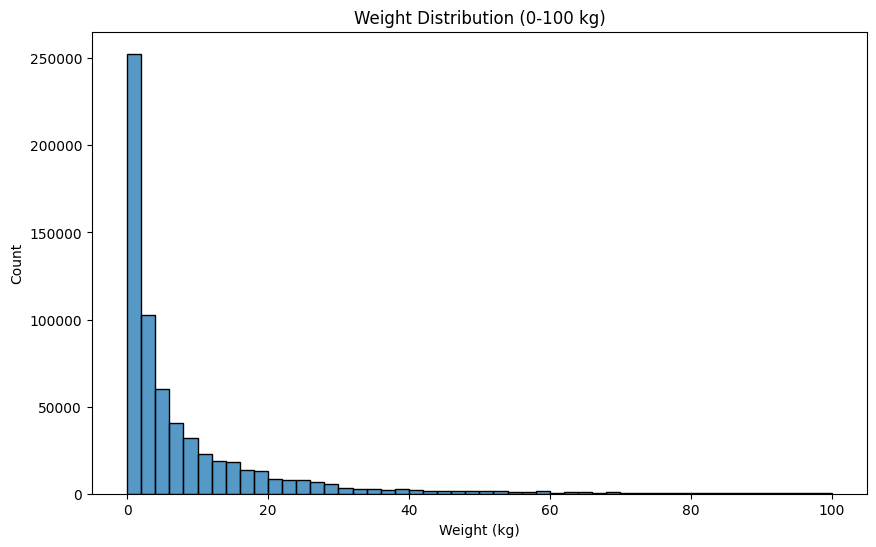

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['weight'] <= 100], x='weight', bins=50)
plt.title('Weight Distribution (0-100 kg)')
plt.xlabel('Weight (kg)')
plt.ylabel('Count')
plt.show()

### Shipment type analysis

The elements of shipment type don't have any formatting problems

In [14]:
shipment_types = df['shipment_type'].value_counts()
print("\nUnique shipment types and counts:")
print(shipment_types)



Unique shipment types and counts:
shipment_type
Parcel      597076
Document     59726
Name: count, dtype: int64


### Insurance type analysis

The elements of insurance type don't have any formattign problems

In [15]:
insurance_types = df['insurance_type'].value_counts()
print("\nUnique insurance types and counts:")
print(insurance_types)


Unique insurance types and counts:
insurance_type
No_Insurance         609418
Premium_Insurance     31017
Basic_Insurance       16367
Name: count, dtype: int64


### Booking state analysis

The elements are as described in the documentation

In [16]:
booking_states = df['booking_state'].value_counts()
print("\nUnique insurance types and counts:")
print(booking_states)


Unique insurance types and counts:
booking_state
12    656767
19        26
10         5
11         2
7          1
16         1
Name: count, dtype: int64


### Margin features analysis

Negative margin could mean that they had to do some refunds

In [17]:
stats = df['margin'].describe()
nulls = df['margin'].isna().sum()

print("\nMargin Analysis:")
print(stats)
print(f"\nNull values: {nulls}")


Margin Analysis:
count    552628.000000
mean         20.937577
std          51.335484
min       -1059.350000
25%           3.400000
50%           7.810000
75%          20.140000
max        3511.600000
Name: margin, dtype: float64

Null values: 104174


### Segmentation analysis

High number of null values across some features can be a common pattern

In [18]:
stats = df['segmentation_customer'].unique()
nulls = df['segmentation_customer'].isna().sum()

print("\nSegmentation Analysis:")
print(stats)
print(f"\nNull values: {nulls}")



Segmentation Analysis:
[ 0. nan  1.  2.  6.  3.  4.  5.]

Null values: 109702


### Main industry name analysis

A third of the industry are not present

In [19]:
analyze_missing_values(df, 'main_industry_name_customer')

Total missing values: 199023
Missing percentage: 30.30%


Here we verify the case correctness of the industry name, bay counting the values as they are, then putting them to lower case and comparing them to see if we can spot differences. 
There aren't.

In [20]:
analyze_text_case_consistency(df, 'main_industry_name_customer')


Value counts - original: 362
Value counts - lowercase: 362


### Sector name analysis

The same number of values as for the industry name are missing, which makes sense since they are tied together.

In [21]:
analyze_missing_values(df, 'industry_sector_name_customer')

Total missing values: 199023
Missing percentage: 30.30%


Here we find no formatting issues

In [22]:
analyze_text_case_consistency(df, 'industry_sector_name_customer')


Value counts - original: 19
Value counts - lowercase: 19


### Delivery postal code analysis

A much lower percentage of missing values across the dataset.

In [23]:
analyze_missing_values(df, 'postal_code_delivery')

Total missing values: 14071
Missing percentage: 2.14%


There are case inconsistencies among postal codes:<br>
Postal codes with letters - original count: 11635<br>
Postal codes with letters - lowercase count: 11607

In [24]:
analyze_postal_code(df, 'postal_code_delivery')

Postal codes with letters - original count: 11635
Postal codes with letters - lowercase count: 11607

Case inconsistencies found:

Variants for 'ch65 3en':
['CH65 3EN' 'ch65 3en']

Variants for 'n9y 2e5':
['n9y 2e5' 'N9Y 2E5']

Variants for 'j2s 8l2':
['J2S 8L2' 'j2s 8l2']

Variants for 'ng156dw':
['NG156DW' 'ng156dw']

Variants for 'n2r 1h8':
['N2R 1H8' 'n2r 1h8']


This way we handle the inconsistencies.

In [25]:
df['postal_code_delivery'] = df['postal_code_delivery'].apply(standardize_postal_code)

### Delivery city analysis

No delivery cicy has missing values.

In [26]:
analyze_missing_values(df, 'city_delivery')

Total missing values: 0
Missing percentage: 0.00%


Lots of cities with inconsistencies in the case formatting:<br>
City counts - original: 69883<br>
City counts - lowercase: 59104

In [27]:
analyze_text_case_consistency(df, 'city_delivery')


Value counts - original: 69883
Value counts - lowercase: 59104

Case inconsistencies found:

Variants for 'hamburg':
['Hamburg' 'HAMBURG' 'hamburg' 'HAmburg' 'hAMBURG']

Variants for 'berlin':
['Berlin' 'BERLIN' 'berlin' 'bERLIN']

Variants for 'münchen':
['München' 'MÜNCHEN' 'münchen']

Variants for 'köln':
['Köln' 'köln' 'KÖLN' 'kÖLN']

Variants for 'bremen':
['Bremen' 'BREMEN' 'bremen']


In [28]:
# Standardize city case format
df['city_delivery'] = df['city_delivery'].str.lower().str.title()

###  Delivery country name analysis

In this feature , which seems to be the country, we have a small amount of missing values.

In [29]:
analyze_missing_values(df, 'name_country_delivery')

Total missing values: 27321
Missing percentage: 4.16%


No inconsistencies.

In [30]:
analyze_text_case_consistency(df, 'name_country_delivery')



Value counts - original: 176
Value counts - lowercase: 176


In [31]:
print("\nFirst 5 name_pickup values:")
print(df['name_country_delivery'].head())


First 5 name_pickup values:
0    Germany
1    Germany
2    Germany
3      China
4    Germany
Name: name_country_delivery, dtype: object


### Iso country code delivery analysis

In [32]:
analyze_missing_values(df, 'iso_country_code_delivery')

Total missing values: 27341
Missing percentage: 4.16%


In [33]:
df["iso_country_code_delivery"].head()

0    DE
1    DE
2    DE
3    CN
4    DE
Name: iso_country_code_delivery, dtype: object

In [34]:
df['iso_country_code_delivery'].unique()

array(['DE', 'CN', 'NL', 'MX', 'PL', nan, 'CO', 'GB', 'MY', 'SG', 'AE',
       'IT', 'PT', 'AT', 'CH', 'LT', 'CZ', 'JO', 'LU', 'EC', 'BE', 'OM',
       'AU', 'IN', 'HK', 'KR', 'NG', 'GH', 'RO', 'HR', 'ID', 'GR', 'JP',
       'SI', 'FR', 'LV', 'DK', 'NZ', 'KZ', 'PA', 'ES', 'HU', 'IL', 'SE',
       'LK', 'CA', 'CI', 'IE', 'IC', 'MT', 'FI', 'BG', 'RS', 'AO', 'QA',
       'CL', 'EG', 'BR', 'BD', 'NO', 'SK', 'DZ', 'PE', 'BB', 'CY', 'AG',
       'EE', 'SA', 'MD', 'BH', 'HN', 'MG', 'IS', 'PK', 'BJ', 'DO', 'MA',
       'LB', 'AR', 'AL', 'BF', 'AM', 'AZ', 'JM', 'BA', 'PH', 'MV', 'BI',
       'GN', 'GP', 'KW', 'KV', 'MU', 'GF', 'SC', 'MM', 'MR', 'KE', 'SV',
       'RE', 'MK', 'PY', 'MZ', 'IQ', 'CR', 'FJ', 'IM', 'BO', 'CV', 'GE',
       'LI', 'SN', 'CM', 'ME', 'MO', 'KH', 'NI', 'KG', 'LY', 'GT', 'NC',
       'HT', 'PF', 'PR', 'ET', 'MW', 'BW', 'MN', 'LC', 'MQ', 'TG', 'BS',
       'GI', 'MC', 'SL', 'NP', 'CG', 'NE', 'ML', 'KY', 'SR', 'DM', 'AW',
       'SD', 'ER', 'GW', 'SM', 'BN', 'AF', 'GM', 'GY

In [35]:
analyze_text_case_consistency(df, 'iso_country_code_delivery')


Value counts - original: 175
Value counts - lowercase: 175


### Delivery continent analysis

In [36]:
analyze_missing_values(df, 'continent_delivery')

Total missing values: 27321
Missing percentage: 4.16%


The format is respected across the unique values.

In [37]:
print(df['continent_delivery'].unique())

['Europe' 'Asia' 'America' nan 'Australia' 'Africa']


### EU delivery analysis

In [38]:
analyze_missing_values(df, 'EU_delivery')

Total missing values: 27321
Missing percentage: 4.16%


It's boolean.

In [39]:
print(df['EU_delivery'].unique())

[ 1.  0. nan]


### Domain name analysis

In [40]:
analyze_missing_values(df, 'domain_name_delivery')

Total missing values: 0
Missing percentage: 0.00%


The nomain name has an established format which is respected.

In [41]:
print(df['domain_name_delivery'].unique())

['DE' 'ES' 'FR' 'CH' 'BE' 'AT' 'NL']


### Postal code pickup analysis

In [42]:
analyze_missing_values(df, 'postal_code_pickup')

Total missing values: 1116
Missing percentage: 0.17%


In [43]:
analyze_postal_code(df, 'postal_code_pickup')

Postal codes with letters - original count: 1194
Postal codes with letters - lowercase count: 1193

Case inconsistencies found:

Variants for 's60 1bx':
['s60 1bx' 'S60 1BX']


In [44]:
df['postal_code_pickup'] = df['postal_code_pickup'].apply(standardize_postal_code)

### City pickup analysis

In [45]:
analyze_missing_values(df, 'city_pickup')

Total missing values: 1
Missing percentage: 0.00%


In [46]:
analyze_text_case_consistency(df, 'city_pickup')


Value counts - original: 13147
Value counts - lowercase: 11817

Case inconsistencies found:

Variants for 'hamburg':
['Hamburg' 'HAMBURG' 'hamburg' 'HAmburg']

Variants for 'kiel':
['Kiel' 'KIEL']

Variants for 'berlin':
['Berlin' 'BERLIN']

Variants for 'bremen':
['Bremen' 'BREMEN' 'bremen']

Variants for 'köln':
['Köln' 'köln' 'KÖLN']


In [47]:
df['city_pickup'] = df['city_pickup'].str.lower().str.title()

### Name Service Analysis

In [48]:
analyze_missing_values(df, 'name_service')

Total missing values: 0
Missing percentage: 0.00%


In [49]:
analyze_text_case_consistency(df, 'name_service')


Value counts - original: 258
Value counts - lowercase: 253

Case inconsistencies found:

Variants for 'express national':
['Express National' 'Express national']

Variants for 'international economy':
['international economy' 'International Economy']

Variants for 'express 12:00 national':
['Express 12:00 National' 'Express 12:00 national']

Variants for 'normal parcel international':
['Normal Parcel International' 'Normal Parcel international']

Variants for 'express 12:00 import':
['Express 12:00 Import' 'EXPRESS 12:00 Import']


In [50]:
df['name_service'] = df['name_service'].str.lower().str.title()

### Service Type analysis

In [51]:
analyze_missing_values(df, 'service_type')

Total missing values: 0
Missing percentage: 0.00%


The format is stardard across all entries.

In [52]:
df['service_type'].unique()

array(['Standard', 'Express', 'Import', 'Third_Country', 'Special'],
      dtype=object)

### Transport type analysis

In [53]:
analyze_missing_values(df, 'transport_type')

Total missing values: 0
Missing percentage: 0.00%


The format is standard across entries.

In [54]:
df['transport_type'].unique()

array(['Standard', 'Express', 'Standard_Palette', 'Express_Palette',
       'Special'], dtype=object)

### Name Carrier analysis

In [55]:
analyze_missing_values(df, 'name_carrier')

Total missing values: 0
Missing percentage: 0.00%


The format is consistent across all the instances.

In [56]:
df['name_carrier'].unique()

array(['UPS', 'FedEx', 'TNT', 'DPD', 'DSV Road', 'DHL', 'DHL S', 'GLS',
       'Der Kurier', 'Aramex', 'Correos', 'Chronopost', 'Bpost',
       'Post AT', 'SkyNet'], dtype=object)

### lms plus analysis

In [57]:
analyze_missing_values(df, 'lms_plus')

Total missing values: 0
Missing percentage: 0.00%


The values are consistent.

In [58]:
df['lms_plus'].unique()

array([0, 1])

### Is Master analysis

In [59]:
analyze_missing_values(df, 'is_master_customer')

Total missing values: 0
Missing percentage: 0.00%


The boolean consistency is respected.

In [60]:
df['is_master_customer'].unique()

array([ True, False])

### Drop non needed features

They won't be seen again since they were registered in the past, and this is not a time series problem.

In [61]:
date_columns_to_drop = [col for col in df.columns if 'full_date' in col or 'created_date' in col]

# Drop the columns
df = df.drop(columns=date_columns_to_drop)

In [62]:
df.columns

Index(['shipment_id', 'customer_price', 'expected_carrier_price',
       'final_carrier_price', 'weight', 'shipment_type', 'insurance_type',
       'customer_id', 'domain_name', 'booking_state', 'lms_plus', 'exworks_id',
       'margin', 'domain_name_customer', 'main_industry_name_customer',
       'industry_sector_name_customer', 'segmentation_customer',
       'sequence_number_customer', 'structure_number_customer',
       'is_master_customer', 'domain_name_delivery', 'postal_code_delivery',
       'city_delivery', 'name_country_delivery', 'iso_country_code_delivery',
       'continent_delivery', 'EU_delivery', 'domain_name_pickup',
       'postal_code_pickup', 'city_pickup', 'name_country_pickup',
       'iso_country_code_pickup', 'continent_pickup', 'EU_pickup',
       'name_service', 'service_type', 'transport_type', 'domain_name_service',
       'name_carrier', 'domain_name_carrier', 'year_pickup_date',
       'month_pickup_date', 'quarter_pickup_date', 'year_delivery_date',
    

### Save dataset

In [63]:
# Save the flattened dataset with proper formatting
output_file = '../datasets/preprocessed_flattened_dataset.csv'

# Save to CSV
df.to_csv(output_file, index=False)